# TRIMP: A methodological introduction

In this notebook we give you an overview of different methods to calculate a training load based on the heart rate. A training load can be defined as 

$$ load = volume * intensity $$

where volume is often interpreted as time interval. Beforehand, we introduce you to the theoretical grounds of heart rate based loads.

## Theoretical Background

Bannisters TRIMP (TRaining IMPulse) is a training load parameter based on heart rate during a training session. To calculate TRIMP for a given period of time you need the average heart rate expressed on a standardized scale (heart reate reserve) from 0 to 1:

$$
\Delta HR = \frac{HR{avg} -HR{min}}{HR{max}-HR{min}}
$$

Consequently, dHR can be multiplied with time spent to derive the training load:

$$
Load =  \Delta HR * t[min] 
$$

To account for increased physical stress in strenous exercise, an exponential weighting was suggested: 

$$
TRIMP = \Delta HR * t *(a*e^{b*\Delta HR})
$$

### Where do a and b come from?

This multiplying factor increases the resulting load in high effort exercise (~90% dHR) by about 4 to 5 times, based on the coefficients in the original reasearch. Bannister estimated the coefficients a and b for men (a=0.64, b=1.92) and women (a=0.86, b=1.67) based on data from incremental tests. To do so, they used lactate at each stage as independent variable and dHR as predictor:

$$ 
Lactate \sim a*exp(b*\Delta HR) 
$$

## Calculus
Let`s get ready to calculate TRIMP based on training data. First we import some libraries



In [2]:
import pandas as pd 
import numpy as np 

In [3]:
df = pd.read_csv('20200130_185831_22_John_mackillop_samples.csv')
df = df.dropna()
df

,Uhrzeit,Uhrzeit.1,HF [S/min],Geschwindigkeit [km/h],Distanz [m],Beschleunigung [m/s²],Schrittfrequenz
0,00:00:00.0,17:59:52.0,121.0,0.00,0.0,0.00,0
1,00:00:00.1,17:59:52.1,121.0,0.00,0.0,0.00,0
2,00:00:00.2,17:59:52.2,121.0,0.00,0.0,0.00,0
3,00:00:00.3,17:59:52.3,121.0,0.00,0.0,0.00,0
4,00:00:00.4,17:59:52.4,121.0,0.00,0.0,0.00,0
...,...,...,...,...,...,...,...
92795,02:34:39.5,20:34:31.5,92.0,2.12,8952.0,-0.07,39
92796,02:34:39.6,20:34:31.6,92.0,1.94,8952.0,-0.17,39
92797,02:34:39.7,20:34:31.7,92.0,1.82,8952.1,-0.28,39
92798,02:34:39.8,20:34:31.8,92.0,1.71,8952.1,-0.38,39


<AxesSubplot:>

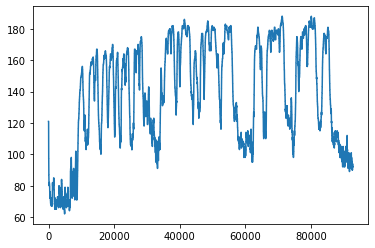

In [4]:
df['HF [S/min]'].plot()

In [11]:
t_min = len(df)/10/60 

HRmin = 40
HRmax = 200
df['dhr'] = (df['HF [S/min]'] - HRmin)  / (HRmax - HRmin)
avg_dhr = df['dhr'].mean()

trimp = t_min * avg_dhr * 0.86 *np.exp(1.67 * avg_dhr)

0.86 *np.exp(1.67 * avg_dhr)

2.4056490172640332

## Cumulative TRIMP

In [6]:
df['t'] = pd.to_datetime(df['Uhrzeit'])
df=df.set_index('t')


In [8]:
def cTRIMP(df, freq):
    
    df_int=df.resample(freq).mean().interpolate('linear')

    dt = df_int.index.to_series().diff()
    df_int['dt'] = dt.dt.total_seconds()/60

    df_int['trimp'] = df_int['dt'] * df_int['dhr'] * \
        0.86 * np.exp(1.67 * df_int['dhr'])
    return np.sum(df_int['trimp'])

In [9]:
test = cTRIMP(df,'30min')
test

235.1855715763858

In [10]:
df_int['min']*60

NameError: name 'df_int' is not defined

In [5]:
df['min'] = pd.to_timedelta(df['Uhrzeit']).dt.total_seconds()/60

In [6]:
df['TRIMP'] = df['min'].diff() * df['dhr'] * 0.86 *np.exp(1.67 * df['dhr'])
cTRIMP = df['TRIMP'].sum()
cTRIMP

270.32935236211654

## Heart rate zone TRIMP

In [7]:
# function that retrieves summed up values for iv when dv is in bins of LowThresh
def histo(LowThresh, dv, iv):
    HighThresh = np.append(LowThresh[1:], 1e5)
    Hist_iv = []
    for i in range (0, len(LowThresh)):
        mask = (dv >= LowThresh[i]) & (dv < HighThresh[i])
        Hist_iv.append(np.sum(iv[mask]))
    return np.array(Hist_iv)

In [8]:
hrz = [.65, .71, .78, .85, .92]
dhr = df['dhr']
m = df['min'].diff()

t_hrz = histo(hrz,dhr,m)

weights = [1.25, 1.71, 2.54, 3.61, 5.16]
mTRIMP = np.sum(t_hrz * weights)
mTRIMP





196.21983333333336

[9.399999999999999]
[17.433333333333355]
[23.06666666666662]
[26.35000000000005]
[0.1833333333333229]


[9.399999999999999,
 17.433333333333355,
 23.06666666666662,
 26.35000000000005,
 0.1833333333333229]

array([0.00166667, 0.00166667, 0.00166667, ..., 0.00166667, 0.00166667,
       0.00166667])